In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Stage : plans PIV
"""
DataFolder="C:/Users/Julie_000/Desktop/Stage" 

# Champs bidimensionnels de vitesse by Clément

In [3]:
# Importation des librairies
from mat4py import loadmat #pour charger des .mat
import matplotlib.pyplot as plt # pour tracer les figures
plt.rcParams['figure.figsize'] = [8, 4.5] # taille par dÃ©faut des figures qu'on trace
import os # pour modifier le dossier de travail
import numpy as np # pour travailler avec des array
from pathlib import Path # Pour rendre les Path compatibles entre Mac et Windows
from matplotlib import rc #Les trois prochaines lignes pour que Ã§a ressemble Ã  latex
rc('font', size=16)
rc('text', usetex=True)
import sys
import matplotlib.cm as cm #colormaps
from matplotlib.colors import Normalize #Pour l'utilisation des couleurs dans quiver
import scipy as sc #pour l'analyse

## Définition des fonctions

In [4]:
# Definition des fonctions
def PIV(prof,manips): 
    """retourne les données des plans pour la bonne profondeur"""
    
    if prof==5:
        piv=manips['piv5']
    elif prof==10:
        piv=manips['piv10']
    elif prof==15:
        piv=manips['piv15']
    else:
        return("prof n'a pas une valeur acceptable")   
    return(piv)

def donnees(prof,plan,manips):
    """Retourne les tableaux de données pour le plan choisi de la profondeur donnée"""
    
    piv=PIV(prof,manips)
    u=np.array(piv[plan]['u'])
    v=np.array(piv[plan]['v'])
    x=np.array(piv[plan]['x'])
    y=np.array(piv[plan]['y'])
    return(u,v,x,y)

## Chargement des données

In [5]:
# Chargement des données:
os.chdir(Path(DataFolder)) # se place dans le dossier où est rangée la manip
manips=loadmat('PIVnagseul.mat') # Charge les données dans la variable manip

prof=10 # Choisi sur quelle profondeur d'eau travailler (5, 10 ou 15 mm)
plan=2
    
u,v,x,y=donnees(prof, plan, manips)

## Plot du champ de vitesse d'un plan choisi pour une profondeur donnée

C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Julie_000\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


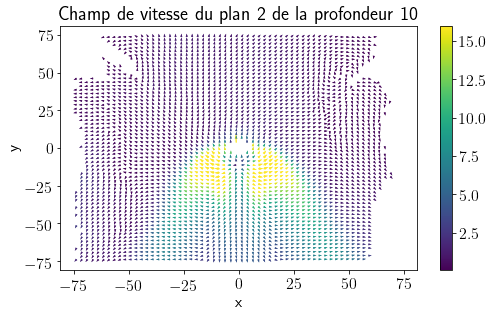

In [6]:
%matplotlib notebook
"Tracé du champ de vitesse pour la profondeur et le plan choisi"

## Pour mieux les représenter, Clément bidouille la colormap
velocity=np.sqrt(u**2+v**2)
velmax=np.mean(velocity)+3*np.std(velocity)#norme maximale représentée sur la colormap borne sup arbitraire
colors = velocity
colors[velocity>velmax]=velmax
colormap=cm.viridis#colormap
norm = Normalize()
norm.autoscale(colors)
    
##plot    
plt.subplots() #pour pas que le plot soit remplacé à chaque fois
cb=plt.colorbar(plt.quiver(x,y,u/velocity,v/velocity,colors)) #pour la barre de couleur
plt.title("Champ de vitesse du plan {} de la profondeur {}".format(plan,prof))
plt.xlabel("x")
plt.ylabel("y")
plt.quiver(x,y,u/velocity,v/velocity,colors)#quiver pour plotter des champs de vecteurs

# Calcul de la divergence bidimensionnelle

## Tentative naïve : différencier sans lisser

### Définition des fonctions


In [30]:
#Définition des fonctions

def deriv(y,x,axis):
    """Dérive un tableau 2D y par rapport à x suivant un axe donné"""
    if axis==0:
        return((y[1:,:]-y[:-1,:])/(x[1:,:]-x[:-1,:]))#Donc là le tableau est de taille (n-1,n)
    if axis==1:
        return((y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1]))#Donc là le tableau est de taille (n,n-1)
    return("deriv ne fonctionne que pour des tableaux 2D")
    

def abcisse(x,axis):
    """somme discrète x[i+1]+x[i]/2 suivant un axe donné"""
    if axis==0:
        return((x[1:,:]+x[:-1,:])/2)
    if axis==1:
        return((x[:,1:]+x[:,:-1])/2)
    return("deriv ne fonctionne que pour des tableaux 2D")
        
    
def good_shape(a,b,n):
    "remise à la bonne shape des tableaux a et b pour pouvoir ensuite les sommer"
    "Ne fonctionne que dans ce cas précis avec des tableaux (n,n-1) et (n-1,n) et donne un tableau (n-1,n-1)"
    #donc on perd des données, je ne sais pas comment faire autrement...
    if np.shape(a)[0]==n:
        return(a[:-1,:],b[:,:-1])
    if np.shape(a)[1]==n:
        return(a[:,:-1],b[:-1,:])
    return("les dimensions des array ne conviennent pas pour l'usage de good_shape, ou problème avec n")
 
    
def divergence2D(a,b):
    "juste somme d'array"
    if np.shape(a)==np.shape(b):
        return(a+b)
    return("les array n'ont pas la bonne shape")

In [34]:
"Petits tests"
a=np.reshape(np.arange(1,26),(5,5))
b=np.reshape(np.arange(1,76,3),(5,5))
da_0=deriv(a,b,1)
da_1=deriv(a,b,0)
#print(np.shape(da_0),np.shape(da_1))

da_0,da_1=good_shape(da_0,da_1,5)

print(np.shape(da_0),np.shape(da_1))

(4, 4) (4, 4)


### chargement des tableaux

In [39]:
"Dérivation"
du,dv=deriv(u,x,1),deriv(v,y,0)
dx,dy=abcisse(x,1),abcisse(y,0)

"Remise à la bonne taille"
du,dv=good_shape(du,dv,60)

"somme des tableaux"
div = divergence2D(du,dv)
print(np.shape(div))

(59, 59)


### premier plot

<IPython.core.display.Javascript object>


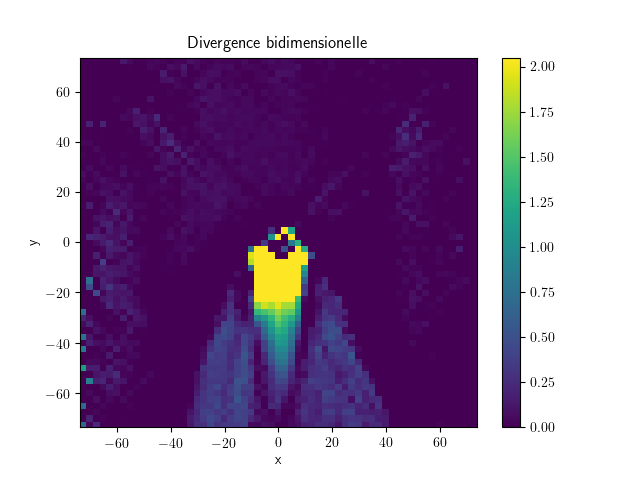

In [69]:
#%matplotlib notebook
colors_div = div
colormap=cm.viridis#colormap
norm = Normalize()
norm.autoscale(colors)
    
##plot 
plt.title("Divergence bidimensionelle")
plt.colorbar(plt.pcolormesh(x,y,div,cmap=colormap,norm=norm))
plt.xlabel("x")
plt.ylabel("y")
plt.pcolormesh(x,y,div,cmap=colormap,norm=norm)




In [60]:
#%matplotlib notebook
"Je ne comprends pas pourquoi cette cellule n'affiche pas de graph !!"

divmax=np.mean(div)+np.std(div)#norme maximale représentée sur la colormap borne sup arbitraire
colors[div>divmax]=divmax
plt.title("Divergence bidimensionelle")
plt.xlabel("x")
plt.ylabel("y")
plt.pcolormesh(x,y,div,cmap=colormap,norm=norm)

### Représentation et affinage